# Calculate the CT correlation matrix for each subject, both in GSP and HCP
## Schaefer 400, 7 network parcellation

Using already available data given by Sofie in .mat file, i.e., CT values, in fsa5 and conte69 atlases -> converting to Schaefer 400 using enigma toolbox https://enigma-toolbox.readthedocs.io/en/latest/pages/13.01.apireference/generated/enigmatoolbox.utils.parcellation.surface_to_parcel.html#enigmatoolbox.utils.parcellation.surface_to_parcel

In [18]:
# General
import os
import sys
import numpy as np
import pandas as pd
import csv
from math import isnan
import statistics

# Computing
import scipy.io  # loadmat
from scipy import stats
import sklearn 
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM

# Visualisation
import matplotlib.pyplot as plt 
import seaborn as sns
import vtk
from IPython.display import display
import matplotlib.collections as clt
import ptitprince as pt

# Neuroimaging
import nibabel
import nilearn
from brainstat.datasets import fetch_parcellation
from enigmatoolbox.permutation_testing import spin_test, shuf_test
from enigmatoolbox.utils.parcellation import surface_to_parcel 

# Gradients
import brainspace
from brainspace.datasets import load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels

## Define directories

In [2]:
codedir = os.path.abspath('')  # obtain current direction from which script is runnning

datadir = '/data/p_02667/sex_diff_gradients/data/'

dataout_gsp = '/data/p_02667/sex_diff_gradients/data/ct_matrices/GSP/'
dataout_hcp = '/data/p_02667/sex_diff_gradients/data/ct_matrices/HCP/'

# Data

## Load demographic data (for subject IDs) -> won't need

In [ ]:
GSP_demographics = pd.read_csv(datadir+'GSP/GSP_list_140630.csv')  
print(f'Sample with demographic data: N = {len(GSP_demographics)}')

Sample with demographic data: N = 1570


In [ ]:
# given that Subject_ID format is Sub****_Ses1, only keeping the Sub**** part to name the .csv files
GSP_demographics.Subject_ID[0].split('_')[0]

'Sub0001'

In [ ]:
GSP_demographics.Subject_ID

0       Sub0001_Ses1
1       Sub0002_Ses1
2       Sub0003_Ses1
3       Sub0004_Ses1
4       Sub0005_Ses1
            ...     
1565    Sub1566_Ses1
1566    Sub1567_Ses1
1567    Sub1568_Ses1
1568    Sub1569_Ses1
1569    Sub1570_Ses1
Name: Subject_ID, Length: 1570, dtype: object

## Load CT data

bianca_ct.mat file sent by Sofie - contains:
- GSP : 1570 subjects x 20484 vertices  # fsa5
- GSPdata : 1 -> weird file
- HCP : 1206 subjects x 20484 vertices  # fsa5
- HCPfs32k : 1206 subjects x 64984 vertices  # conte69 -> officially formatted HCP CT files, **use this!**
- HCPid : 1206 subjects


*Notes*
- *I noticed that, when mapping the vertices onto schaefer400 for a given subject, I don't get the same results with HCP (fsa5) and HCPfs32k (conte69) ... Decision with Sofie was to just use the officially formatted HCP files*


In [3]:
scipy.io.whosmat(datadir + 'bianca_ct.mat')

[('bianca_ct', (1, 1), 'struct'),
 ('__function_workspace__', (1, 1609736), 'uint8')]

In [4]:
# only taking the matrices from the mat file
bianca_ct = scipy.io.loadmat(datadir + 'bianca_ct.mat')['bianca_ct']

In [8]:
bianca_ct

array([[(array([[3.26796985, 2.49868917, 2.45598364, ..., 1.55726588, 2.12942314,
                3.73088121],
               [2.78464246, 1.75377476, 2.96815395, ..., 3.51134014, 3.9344573 ,
                3.25195694],
               [3.21087742, 3.28334045, 2.44964695, ..., 3.1335268 , 3.06433702,
                2.91318035],
               ...,
               [3.0497148 , 2.67300081, 1.9982475 , ..., 2.93456125, 2.4726181 ,
                2.77994561],
               [2.94211555, 2.08098197, 2.1598618 , ..., 2.74206519, 3.09218979,
                2.89839554],
               [3.18600941, 1.51884472, 3.21059513, ..., 2.90565395, 2.83341765,
                3.36034584]]), MatlabOpaque([(b'', b'MCOS', b'table', array([[3707764736],
                             [         2],
                             [         1],
                             [         1],
                             [         1],
                             [         3]], dtype=uint32))         ],
               

In [9]:
len(bianca_ct[0][0][3][0])

64984

In [10]:
GSP_ct_20484 = bianca_ct[0][0][0]  # GSP : 1570 subjects x 20484 vertices # fsa5
#HCP_ct_20484 = bianca_ct[0][0][2]  # HCP : 1206 subjects x 20484 vertices # fsa5 
HCP_ct_64984 = bianca_ct[0][0][3]  # HCPfs32k : 1206 subjects x 64984 vertices # conte69

# Construct matrices

## **TO DO**
- do i need to z transform??
- MAKE A FUNCTION OUT OF THIS! So that I can reuse this for HCP data

In [20]:
GSP_ct_schaefer400 = []
GSP_global_ct = []

### get the CT data in Schaefer 400 format for all subjects

for i in range(len(GSP_ct_20484)):

    # transform fsa5 surface data to schaefer 400 parcellated data
    sub_ct_schaefer400 = surface_to_parcel(GSP_ct_20484[i], 'schaefer_400_fsa5')  # this function yields array len = 401 (including midline as first array element)

    # deleting first element (index = 0) of the array corresponding to midline in order to yield Schaefer 400 (len = 400) parcellated data
    sub_ct_schaefer400 = np.delete(sub_ct_schaefer400, 0) 
    
    # appending current subject's CT values for 400 parcels to general list of CT 
    GSP_ct_schaefer400.append(sub_ct_schaefer400)
    
    # appending current subject's global CT (mean CT across 400 parcels) to list of global ct
    GSP_global_ct.append(statistics.mean(sub_ct_schaefer400))

    
# make the variable containing Schaefer 400 CT data of all subjects into array    
GSP_ct_schaefer400 = np.array(GSP_ct_schaefer400)  

# make a new column in demographics dataframe with global CT value for each subject   ## MIGHT NEED TO CHANGE TO CLEANED VERSION OF DEMOGRAPHICS DEPENDING ON WHERE I PLACE THIS IN MAIN SCRIPT
GSP_demographics['global_ct'] = GSP_global_ct

In [47]:
GSP_ct_schaefer400.shape

(1570, 400)

In [48]:
# creating lists containing only male and only female CT values (for 400 parcels)
## MIGHT NEED TO CHANGE TO CLEANED VERSION OF DEMOGRAPHICS DEPENDING ON WHERE I PLACE THIS IN MAIN SCRIPT

GSP_ct_schaefer400_M = []  # 665
GSP_ct_schaefer400_F = []  # 905

for i in range(len(GSP_ct_schaefer400)):
    if GSP_demographics.Sex.iloc[i] == "M":
        GSP_ct_schaefer400_M.append(GSP_ct_schaefer400[i])
    elif GSP_demographics.Sex.iloc[i] == "F":
        GSP_ct_schaefer400_F.append(GSP_ct_schaefer400[i])
        
# make the variables containing Schaefer 400 CT data by sex into arrays
GSP_ct_schaefer400_M = np.array(GSP_ct_schaefer400_M) 
GSP_ct_schaefer400_F = np.array(GSP_ct_schaefer400_F) 

### Structural covariance matrices

- TO DO: find how to compute correlation matrix with covariates (sex (for across all subjects only), age, global_ct for all) -> OTHERWISE NEED TO DO BY HAND?
    - pingouin option (through df BUT max two variables; always between "pairs" of variables") https://pingouin-stats.org/generated/pingouin.partial_corr.html
    - ask Bin? Amin? looking for something that will yield correlation matrix

In [49]:
# compute correlation matrix of 400 x 400 parcels for CT across all subjects
GSP_ct_matrix = np.corrcoef(GSP_ct_schaefer400.T)  # need to .T because GSP_ct_schaefer400 is of shape 1570x400, so I want correlations to be computed for the 400 parcels across subjects and not for the 1570 subjects across parcels
print(GSP_ct_matrix.shape)

# compute correlation matrix of 400 x 400 parcels for CT across males
GSP_ct_matrix_M = np.corrcoef(GSP_ct_schaefer400_M.T)  
print(GSP_ct_matrix_M.shape)

# compute correlation matrix of 400 x 400 parcels for CT across females
GSP_ct_matrix_F = np.corrcoef(GSP_ct_schaefer400_F.T)  
print(GSP_ct_matrix_F.shape)

(400, 400)
(400, 400)
(400, 400)


# Compute structural covariance gradients

- TO DO: will need to edit function "compute mean gradients" to input matrix directly (remove first line) -> and make adjustments in code (change inputted data when calling compute mean gradients function -> do Ctrl F)
    - the code below was just to display results, the function will calculate this directly
- then calculate also by sex
- then do analyses specified in notion cortical thickness

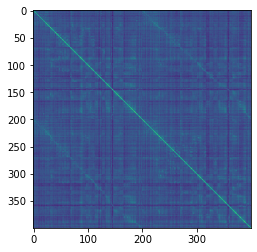

(400, 400)


/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


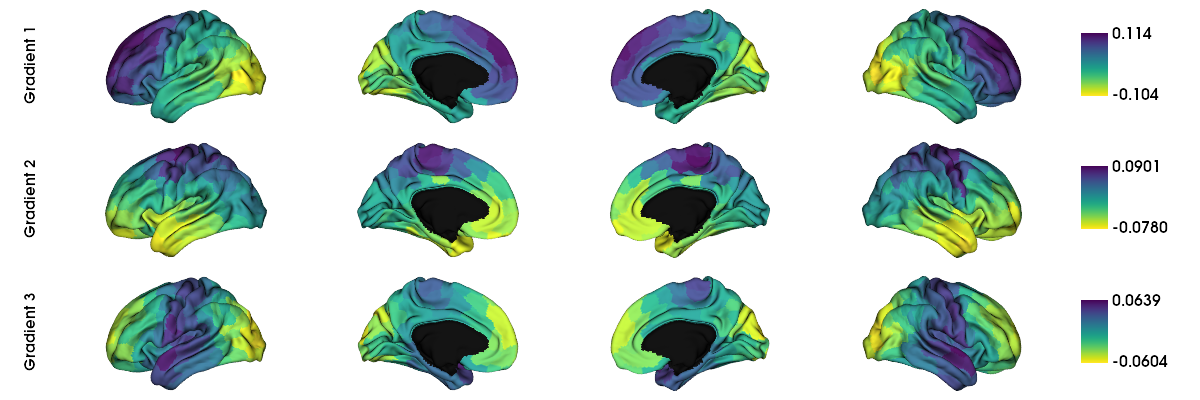

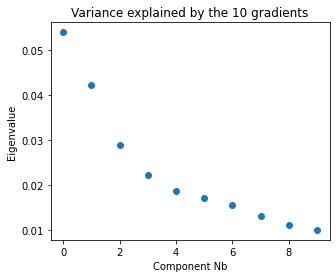

Total amount of variance explained by the 10 gradients (uncorrected sum lambdas): 0.23

Scaled variance explained by individual gradients:
G1: 23.07%
G2: 18.11%
G3: 12.40%



In [53]:
# GradientMaps function used to build the model parameters
mean_grad = GradientMaps(n_components = 10, random_state = 0, approach = 'dme', kernel = 'normalized_angle')

# fit function used to compute the gradients
mean_grad.fit(GSP_ct_matrix)



## plot the mean connectivity matrix and shape

plt.imshow(GSP_ct_matrix)
plt.show()
print(GSP_ct_matrix.shape)


## plot the 3 first mean gradients

# defining labeling scheme and mask
labeling = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()
mask = labeling != 0

# list containing placeholders (None) for the number of gradients I want to plot
grad = [None] * 3

for i in range(3):
    # map the gradient to the parcels
    grad[i] = map_to_labels((mean_grad.gradients_)[:, i], labeling, mask=mask, fill=np.nan)  # mean_grad contains 10 .gradients_ (1 gradient per column) - here I take all rows and individual select column based on gradient I want (first 3)

plot = plot_hemispheres(surf_lh, surf_rh, array_name=grad, embed_nb = True, size=(1200, 400), cmap='viridis_r', color_bar=True, label_text=['Gradient 1', 'Gradient 2', 'Gradient 3'], zoom=1.55)
display(plot)


## plot the variance explained by the 10 gradients

fig, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(mean_grad.lambdas_.size), mean_grad.lambdas_)
ax.set_title("Variance explained by the 10 gradients")
ax.set_xlabel('Component Nb')
ax.set_ylabel('Eigenvalue')
plt.show()

print(f"Total amount of variance explained by the {len(mean_grad.lambdas_)} gradients (uncorrected sum lambdas): {sum(mean_grad.lambdas_):.2f}\n")

# Scaled variance explained by individual gradients: lambda / total(i.e., sum lambdas) * 100 %
print(f"Scaled variance explained by individual gradients:\nG1: {mean_grad.lambdas_[0]/sum(mean_grad.lambdas_)*100:.2f}%\nG2: {mean_grad.lambdas_[1]/sum(mean_grad.lambdas_)*100:.2f}%\nG3: {mean_grad.lambdas_[2]/sum(mean_grad.lambdas_)*100:.2f}%\n")


In [84]:
HCP_ct_schaefer_400 = surface_to_parcel(HCP_ct_20484[1], 'schaefer_400_fsa5')

In [85]:
len(HCP_ct_schaefer_400)

401

In [87]:
HCPfs32k_ct_schaefer_400 = surface_to_parcel(HCP_ct_64984[1], 'schaefer_400_conte69')

In [88]:
len(HCPfs32k_ct_schaefer_400)

401

In [89]:
HCP_ct_schaefer_400 == HCPfs32k_ct_schaefer_400

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [8]:
# only taking the matrices from the mat file
function_workspace = scipy.io.loadmat(datadir + 'bianca_ct.mat')['__function_workspace__']

In [95]:
len(function_workspace[0])  # 1609736

1609736

In [93]:
function_workspace[0]

array([ 0,  1, 73, ...,  0,  0,  0], dtype=uint8)